<a href="https://colab.research.google.com/github/siqitoday/Playground/blob/main/HODL%20Homework1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# initialize the seeds of different random number generators so that the 
# results will be the same every time the notebook is run
keras.utils.set_random_seed(42)

# **Introduction**

Your goal in this exercise is to recognize sentiment from a facial image. To that end, we will use the 2013 FER ('Facial Expression Recognition'). The dataset consists of ~ 36,000 images, each annotated with one of seven labels: 'angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'. Our goals will be to:

1) Build a conv-net from scratch to recognize images.  
2) Use transfer learning as an alternative. 

But first, lets start with grabbing the data itself from Dropbox

In [ ]:
!wget -q -P ./ https://www.dropbox.com/s/ia62dg6kpp3q8wb/fer2013.csv

In [ ]:
data = pd.read_csv('/content/fer2013.csv')
print(data.head())

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


As you can see, each (gray-scale) image is encoded as a list of (2304) pixels that we will reshape into an (48x48) image. This keeps the size of the dataset manageable. Moreover, each image is associated with an emotion label between 0 and 6 that map respectively to the emotions 'angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', and 'neutral'. Let's convert these pixel lists into actual images that we can work with next.  

In [ ]:
pixels = data['pixels'].tolist()
width, height = 48, 48
faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')] # read each face as a 1-d array 
    face = np.asarray(face).reshape(width, height) # reshape the length 2304 1-d array into an 48x48 array
    face = np.stack((face,)*3, axis=-1) # convert single channel to three channels simply by replicating the single channel we have. 
    faces.append(face.astype('float32'))
faces = np.asarray(faces)

emotions = pd.get_dummies(data['emotion']).to_numpy() # each emotion is 'one-hot' encoded as a 7-dim vector
emotions_names = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral') 

Lets take a look at some of these fun images! 

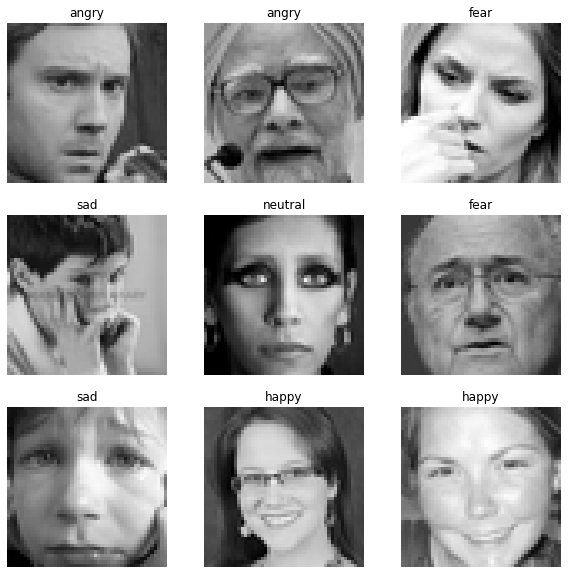

In [ ]:
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.set_title(f"{emotions_names[np.argmax(emotions[i])]}")
    ax.imshow(faces[i].astype('uint8'))
    ax.axis('off')

As in the original dataset, we will reserve the first 28,709 images for training and the rest for testing. 

In [ ]:
train_faces, train_emotions =  faces[:28709], emotions[:28709]
test_faces, test_emotions =  faces[28709:], emotions[28709:]

In [ ]:
print(train_faces.shape, train_emotions.shape)

(28709, 48, 48, 3) (28709, 7)


In [ ]:
print(test_faces.shape, test_emotions.shape)

(7178, 48, 48, 3) (7178, 7)


# **Construct a CNN Model**

We will try a simple CNN on this dataset with three convolutional + pooling layers + one dense layer

In [ ]:
input = keras.Input(shape=train_faces.shape[1:])
x = keras.layers.Rescaling(1./255)(input) #normalizing
x = keras.layers.Conv2D(16, kernel_size=(2, 2), activation="relu", name="Conv_1")(x) # convolutional layer!
x = keras.layers.MaxPool2D()(x) # pooling layer
x = keras.layers.Conv2D(16, kernel_size=(2, 2), activation="relu", name="Conv_2")(x) # convolutional layer!
x = keras.layers.MaxPool2D()(x) # pooling layer
x = keras.layers.Conv2D(16, kernel_size=(2, 2), activation="relu", name="Conv_3")(x) # convolutional layer!
x = keras.layers.MaxPool2D()(x) # pooling layer
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation="relu")(x)   
output = keras.layers.Dense(7, activation="softmax")(x)

model = keras.Model(input, output, name='CNN_model')

In [ ]:
model.summary()

Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 Conv_1 (Conv2D)             (None, 47, 47, 16)        208       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 23, 23, 16)       0         
 g2D)                                                            
                                                                 
 Conv_2 (Conv2D)             (None, 22, 22, 16)        1040      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 11, 11, 16)       0         
 g2D)                                                    

In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [ ]:
epochs = 30
history = model.fit(train_faces, train_emotions, 
          batch_size=64, 
          epochs=epochs, 
          validation_split=0.2)

Epoch 1/30
359/359 [==============================] - 2s 6ms/step - loss: 1.7155 - accuracy: 0.3123 - val_loss: 1.6138 - val_accuracy: 0.3840
Epoch 2/30
359/359 [==============================] - 2s 5ms/step - loss: 1.5699 - accuracy: 0.3937 - val_loss: 1.5319 - val_accuracy: 0.4152
Epoch 3/30
359/359 [==============================] - 2s 5ms/step - loss: 1.4997 - accuracy: 0.4191 - val_loss: 1.4659 - val_accuracy: 0.4361
Epoch 4/30
359/359 [==============================] - 2s 5ms/step - loss: 1.4419 - accuracy: 0.4459 - val_loss: 1.4256 - val_accuracy: 0.4565
Epoch 5/30
359/359 [==============================] - 2s 5ms/step - loss: 1.3924 - accuracy: 0.4676 - val_loss: 1.4100 - val_accuracy: 0.4634
Epoch 6/30
359/359 [==============================] - 2s 5ms/step - loss: 1.3424 - accuracy: 0.4866 - val_loss: 1.4097 - val_accuracy: 0.4653
Epoch 7/30
359/359 [==============================] - 2s 5ms/step - loss: 1.2941 - accuracy: 0.5050 - val_loss: 1.3753 - val_accuracy: 0.4875
Epoch 

In [ ]:
score = model.evaluate(test_faces, test_emotions)
print("Test accuracy:", score[1])

225/225 [==============================] - 1s 2ms/step - loss: 3.0538 - accuracy: 0.4845
Test accuracy: 0.4845360815525055


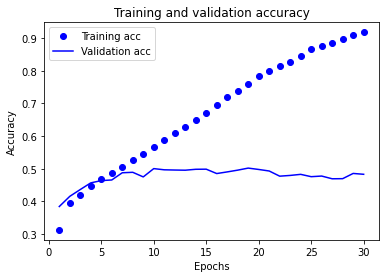

In [ ]:
history_dict = history.history
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# **Data Augmented CNN Model** 


***Data Augmentation:*** 

The basic idea of augmentation is to slightly alter the image so that the value of the dependent variable (i.e. the category that it belongs to) doesn't change.

In [ ]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomZoom(0.2),
    ]
)

Lets quickly visualize what an augmentation does ... 

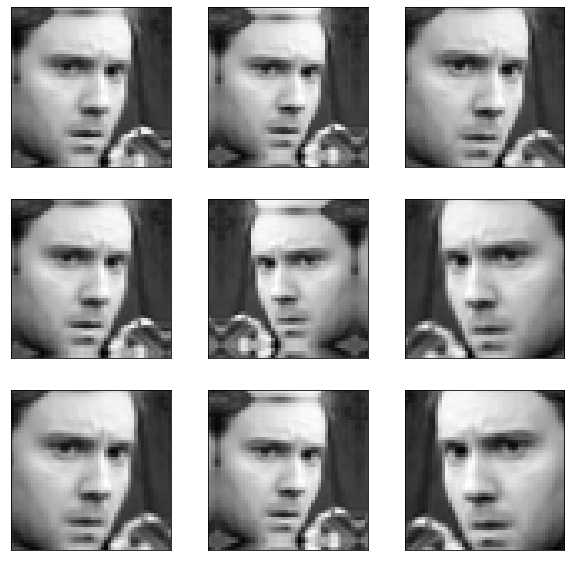

In [ ]:
augmented_images = [data_augmentation(np.expand_dims(train_faces[0],axis=0)) for i in range(9)]
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1, xticks=[], yticks=[])
    ax.imshow(tf.keras.preprocessing.image.array_to_img(augmented_images[i][0]))

In [ ]:
input = keras.Input(shape=train_faces.shape[1:])

x = data_augmentation(input)  

x = keras.layers.Rescaling(1./255)(x)

x = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_1")(x) # convolutional layer!
x = keras.layers.MaxPool2D()(x) # pooling layer
x = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_2")(x) # convolutional layer!
x = keras.layers.MaxPool2D()(x) # pooling layer
x = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_3")(x) # convolutional layer!
x = keras.layers.MaxPool2D()(x) # pooling layer
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation="relu")(x)   
output = keras.layers.Dense(7, activation="softmax")(x)

model = keras.Model(input, output, name='augmented_CNN_model')

In [ ]:
model.summary()

Model: "augmented_CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 sequential_6 (Sequential)   (None, 48, 48, 3)         0         
                                                                 
 rescaling_11 (Rescaling)    (None, 48, 48, 3)         0         
                                                                 
 Conv_1 (Conv2D)             (None, 47, 47, 32)        416       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 Conv_2 (Conv2D)             (None, 22, 22, 32)        4128      
                                               

In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [ ]:
epochs = 20
history = model.fit(train_faces, train_emotions, 
          batch_size=64, 
          epochs=epochs, 
          validation_split=0.2)

Epoch 1/20
359/359 [==============================] - 3s 7ms/step - loss: 1.7301 - accuracy: 0.2971 - val_loss: 1.6037 - val_accuracy: 0.3871
Epoch 2/20
359/359 [==============================] - 2s 6ms/step - loss: 1.5462 - accuracy: 0.3997 - val_loss: 1.4296 - val_accuracy: 0.4511
Epoch 3/20
359/359 [==============================] - 2s 6ms/step - loss: 1.4488 - accuracy: 0.4417 - val_loss: 1.3671 - val_accuracy: 0.4730
Epoch 4/20
359/359 [==============================] - 2s 6ms/step - loss: 1.3848 - accuracy: 0.4691 - val_loss: 1.3171 - val_accuracy: 0.5000
Epoch 5/20
359/359 [==============================] - 2s 6ms/step - loss: 1.3333 - accuracy: 0.4871 - val_loss: 1.2824 - val_accuracy: 0.5118
Epoch 6/20
359/359 [==============================] - 2s 6ms/step - loss: 1.2954 - accuracy: 0.5075 - val_loss: 1.2743 - val_accuracy: 0.5080
Epoch 7/20
359/359 [==============================] - 2s 6ms/step - loss: 1.2668 - accuracy: 0.5158 - val_loss: 1.2390 - val_accuracy: 0.5284
Epoch 

In [ ]:
score = model.evaluate(test_faces, test_emotions)
print("Test accuracy:", score[1])

225/225 [==============================] - 1s 3ms/step - loss: 1.2103 - accuracy: 0.5750
Test accuracy: 0.5749512314796448


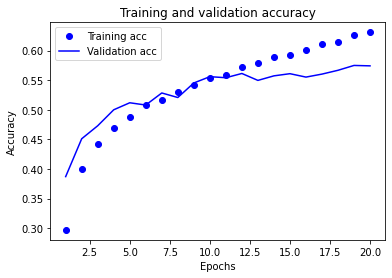

In [ ]:
history_dict = history.history
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# **Constructing a Transfer Learning Model**

Next, we architect a basic transfer learning model. We will take a slightly different approach from what we saw in class: as opposed to generating feature vectors by running each image through a pre-trained model, we will simply (a) remove the top from an existing pre-trained model, and (b) add a custom designed top. Why are we doing this? Its so that we can 'tweak' the weights of the original pre-trained model to suit our problem.

***Fine Tune Model:*** 

In the stub below, we define a 'fine-tuned' model to stack on top of a pre-trained base model. In contrast with what we did in class, we do not explicitly use the pre-trained model to generate stored features but incorporate it as part of the overall network. 

In [ ]:
top_model = keras.Sequential(
    [
        keras.layers.Flatten(),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(1024, activation='relu'),
    ]
)

***Overall Model:*** 

Below, we take a base-model (the VGG19 model: https://keras.io/api/applications/vgg/) and perform the following steps:
 

1.   Remove the top of the model (include_top=False)
2.   'Freeze' the model's parameters so they do not get impacted by training
3.   Feed the output of the base model to our fine-tune model
4.   Feed the output of our fine-tune model to a soft-max output layer.  
5. **Unfreeze the last 10 layers of the VGG19 model so we can update those weights as well.**



In [ ]:
def construct_model(no_classes, input_shape, metrics=['accuracy']):

  base_model = keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
  )

  # Freeze the base_model
  base_model.trainable = False

  #
  # Create new model on top
  #

  inputs = keras.Input(shape=input_shape)

  x = keras.layers.Rescaling(1./255)(inputs) #normalizing

  # Apply random data augmentation
  x = data_augmentation(x)  

  # The base model contains batchnorm layers. We want to keep them in inference mode
  # when we unfreeze the base model for fine-tuning, so we make sure that the
  # base_model is running in inference mode here. We didn't cover batchnorm 
  # layers in class so just take our word for it :-)
  x = base_model(x, training=False)
  
  # Next we feed the output from our base model to the top model we designed. 
  x = top_model(x)
  
  outputs = keras.layers.Dense(no_classes, activation='softmax')(x)
  
  model = keras.Model(inputs, outputs)
  model.summary()

  #unfreeze the last 10 layers of the model so that some tweaks can be done to the weights of the VGG19 model. 
  for layer in model.layers[-10:]:
      if not isinstance(layer, keras.layers.BatchNormalization): #the batch normalization layer is untouched 
          layer.trainable = True

  model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.2*1e-4), metrics=metrics) #here we choose a different rate for Adam than default for a better convergence
  
  return model

***Training the Overall Model***

In [ ]:
no_classes = 7
NO_EPOCHS = 30
model = construct_model(no_classes,(48,48,3))

history = model.fit(train_faces, train_emotions, epochs=NO_EPOCHS, validation_split=0.2)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 sequential_6 (Sequential)   (None, 48, 48, 3)         0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 sequential_7 (Sequential)   (None, 1024)              1574912   
                                                                 
 dense_30 (Dense)            (None, 7)                 7175      
                                                                 
Total params: 21,606,471
Trainable params: 1,582,087
Non-trainable params: 20,024,384
_________________________________________________________________
Epoch 1/30
718/718 [===================

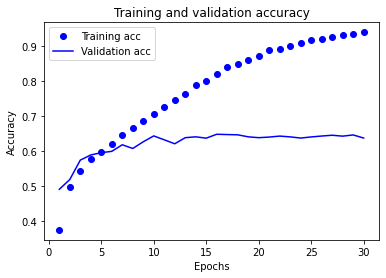

In [ ]:
history_dict = history.history
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
MODEL_FILE_NAME = 'fer2013VGGTransferFinal.h5'
model.save(MODEL_FILE_NAME)

The accuracy for the testing set is improved significantly (the state-of-the-art with tremendous efforts is around 73.3%)

In [ ]:
score = model.evaluate(test_faces, test_emotions)
print("Test accuracy:", score[1])

225/225 [==============================] - 3s 11ms/step - loss: 1.7772 - accuracy: 0.6326
Test accuracy: 0.6326274871826172


In [ ]:
predictions_index = model.predict(test_faces).argmax(axis=1)
actuals_index = test_emotions.argmax(axis=1)

actuals = [emotions_names[i] for i in actuals_index]
predictions = [emotions_names[i] for i in predictions_index]

Check out the confusion matrix

In [ ]:
#df = pd.DataFrame({'Predictions': predictions, 'Actuals': actuals})
#pd.crosstab(df.Predictions, df.Actuals)